#### Handwritten digit generation using Variational Autoencoder (VAE)

In [140]:
#Importing all dependencies

from tensorflow.keras.layers import Input, Dense, Lambda, Reshape
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras import metrics
from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ReLU, PReLU, LeakyReLU,ELU
from tensorflow.keras import activations

import numpy as np
import matplotlib.pyplot as plt

In [141]:
## setting hyperparameter

batch_size = 100
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
np_epoch = 5
epsilon_std = 1.0

In [142]:
# Reparametering - to pass stochastic nature of latent space to Epsilon inoder to do backpropogation
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(tf.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + tf.exp(z_log_var / 2) * epsilon

Encoder

In [145]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

Decoder

In [146]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


Defining VAE

In [147]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


Define loss function

In [150]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
            
    kl_weight=0.0005

    latent_loss = 0.5 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1.0 - z_log_var, axis=1)
    reconstruction_loss = tf.reduce_mean(tf.abs(x-x_decoded_mean), axis=(1))

    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss

vae.compile(optimizer='adam', loss=vae_loss)
vae.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [151]:
# def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
#             z_log_var=z_log_var, z_mean=z_mean,
#             original_dim=original_dim):
#     xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
#     kl_loss = - 0.5 * K.sum(
#         1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#     vae_loss = K.mean(xent_loss + kl_loss)
#     return vae_loss

# vae.compile(optimizer='rmsprop', loss=vae_loss)
# vae.summary()

In [152]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [153]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=np_epoch,
        batch_size=batch_size)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 64us/sample - loss: 0.1334
Epoch 2/5
60000/60000 [==============================] - 3s 58us/sample - loss: 0.1071
Epoch 3/5
60000/60000 [==============================] - 3s 57us/sample - loss: 0.1028
Epoch 4/5
60000/60000 [==============================] - 3s 58us/sample - loss: 0.1008
Epoch 5/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.0997


In [183]:
x_test_encoded.shape

(10000, 2)

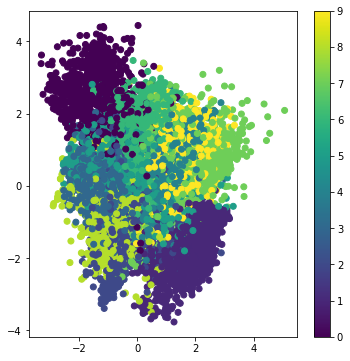

In [177]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

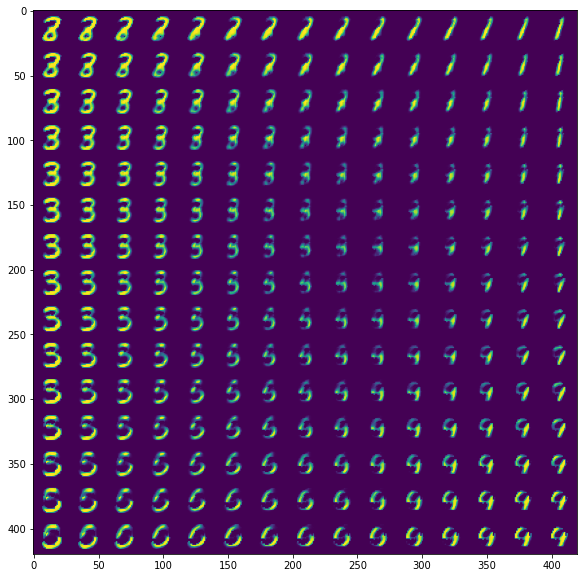

In [165]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()